# Lesson 2: Baseline Email Assistant

This lesson builds an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

We'll start with a simple implementation - one that uses hard-coded rules to handle emails.

![Memory Course App](./img/memory_course_email.png)


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> , notebooks and other files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

## Load API tokens for our 3rd party APIs

In [41]:
import os
from dotenv import load_dotenv
_ = load_dotenv()

## Setup a Profile, Prompt and Example Email

In [42]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [43]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [44]:
# Example incoming email
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

## Define the first part of the agent - triage.

In [95]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [46]:
llm = init_chat_model("openai:gpt-4o-mini")

In [47]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [48]:
llm_router = llm.with_structured_output(Router)

In [49]:
from prompts import triage_system_prompt, triage_user_prompt

In [76]:
# uncomment to view
print(triage_system_prompt)
print(triage_user_prompt)

You are an email triage assistant for {full_name} ({name}).

{user_profile_background}

Your task is to classify incoming emails into one of three categories:

1. **ignore**: {triage_no}
2. **notify**: {triage_notify}
3. **respond**: {triage_email}

{examples}

Analyze each email carefully and classify it based on its content, sender, and context.
From: {author}
To: {to}
Subject: {subject}

Email Content:
{email_thread}

Classify this email as 'ignore', 'notify', or 'respond'.


In [51]:
system_prompt = triage_system_prompt.format(
    full_name=profile["full_name"],
    name=profile["name"],
    examples=None,
    user_profile_background=profile["user_profile_background"],
    triage_no=prompt_instructions["triage_rules"]["ignore"],
    triage_notify=prompt_instructions["triage_rules"]["notify"],
    triage_email=prompt_instructions["triage_rules"]["respond"],
)

In [89]:
#print(f"system prompt: \n: {system_prompt}")

from pprint import pprint

In [90]:
user_prompt = triage_user_prompt.format(
    author=email["from"],
    to=email["to"],
    subject=email["subject"],
    email_thread=email["body"],
)

In [82]:
print(f"user prompt: \n: {user_prompt}")

user prompt: 
: From: Alice Smith <alice.smith@company.com>
To: John Doe <john.doe@company.com>
Subject: Quick question about API documentation

Email Content:

Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice

Classify this email as 'ignore', 'notify', or 'respond'.


In [91]:
result = llm_router.invoke(
    [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
    ]
)

In [ ]:
pprint(result.model_dump())

{'classification': 'respond',
 'reasoning': 'The email is a direct question from a team member, Alice, '
              'regarding the API documentation for a new authentication '
              'service. She is asking for clarification about missing '
              'endpoints and whether they need to be updated, which indicates '
              "it's important for the project's progress. Therefore, this "
              'email requires a response from John.'}


## Main agent, define tools

In [96]:
from langchain_core.tools import tool

In [56]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"

In [57]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"



In [58]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Main agent, define prompt

In [97]:
from prompts import agent_system_prompt
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt.format(
                instructions=prompt_instructions["agent_instructions"],
                **profile
                )
        }
    ] + state['messages']

In [60]:
print(agent_system_prompt)

< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
</ Tools >

< Instructions >
{instructions}
</ Instructions >


In [61]:
from langgraph.prebuilt import create_react_agent

In [62]:
tools=[write_email, schedule_meeting, check_calendar_availability]

In [63]:
agent = create_react_agent(
    "openai:gpt-4o",
    tools=tools,
    prompt=create_prompt,
)

/var/folders/kn/h28x_m3d6xq54mryr0hdxv_m0000gn/T/ipykernel_51213/4175401523.py:1: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(


In [64]:
response = agent.invoke(
    {"messages": [{
        "role": "user", 
        "content": "what is my availability for tuesday?"
    }]}
)

In [65]:
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

You have the following available time slots on Tuesday:

- 9:00 AM
- 2:00 PM
- 4:00 PM

If you need to schedule anything at these times, please let me know!


## Create the Overall Agent

In [66]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [67]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [68]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

## Put it all together

In [69]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile()

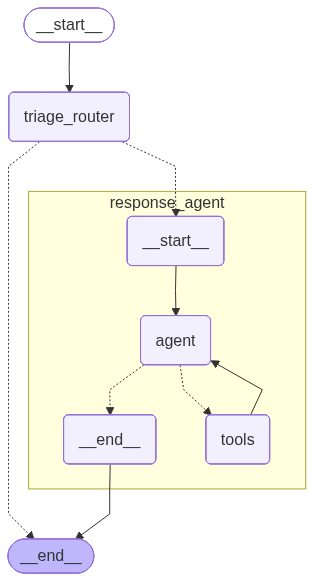

In [70]:
# Show the agent
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [71]:
email_input = {
    "author": "Marketing Team <marketing@amazingdeals.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "🔥 EXCLUSIVE OFFER: Limited Time Discount on Developer Tools! 🔥",
    "email_thread": """Dear Valued Developer,

Don't miss out on this INCREDIBLE opportunity! 

🚀 For a LIMITED TIME ONLY, get 80% OFF on our Premium Developer Suite! 

✨ FEATURES:
- Revolutionary AI-powered code completion
- Cloud-based development environment
- 24/7 customer support
- And much more!

💰 Regular Price: $999/month
🎉 YOUR SPECIAL PRICE: Just $199/month!

🕒 Hurry! This offer expires in:
24 HOURS ONLY!

Click here to claim your discount: https://amazingdeals.com/special-offer

Best regards,
Marketing Team
---
To unsubscribe, click here
""",
}

In [72]:
response = email_agent.invoke({"email_input": email_input})

🚫 Classification: IGNORE - This email can be safely ignored


In [73]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [74]:
response = email_agent.invoke({"email_input": email_input})

📧 Classification: RESPOND - This email requires a response


In [75]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================
Tool Calls:
  write_email (call_5B27rQK4iYfzBVzfpyAXDdQv)
 Call ID: call_5B27rQK4iYfzBVzfpyAXDdQv
  Args:
    to: alice.smith@company.com
    subject: Re: Quick question about API documentation
    content: Hi Alice,

Thank you for reaching out about the API documentation.

The endpoints /auth/refresh and /auth/validate should indeed b